In [1]:
import sys
sys.path.append('/Users/leah/Columbia/courses/19summer/SocialBehavior/SocialBehaviorptc')

In [2]:
from socialbehavior.models.hmm import HMM
from socialbehavior.observations.ar_sigmoid_normal_observation import ARSigmoidNormalObservation
from socialbehavior.distributions.sigmoidnormal import SigmoidNormal
from socialbehavior.transformations.linear import LinearTransformation
from socialbehavior.utils import find_permutation, random_rotation, k_step_prediction

import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm
import sys
import time

In [3]:
import joblib

datasets_processed = joblib.load('/Users/leah/Columbia/courses/19summer/SocialBehavior/tracedata/all_data_3_1')  # a list of length 30, each is a social_dataset

rendered_data = []
for dataset in datasets_processed:
    session_data = dataset.render_trajectories([3,8])  # list of length 2, each item is an array (T, 2). T = 36000
    rendered_data.append(np.concatenate((session_data),axis = 1)) # each item is an array (T, 4)
trajectories = np.concatenate(rendered_data,axis = 0)  # (T*30, 4)

traj29 = rendered_data[29]

In [4]:
arena_xmax = 320
arena_ymax = 370

In [5]:
K = 5
D = 4
T = 36000

bounds = np.array([[-30, arena_xmax + 30], [-30, arena_ymax + 30], [-30, arena_xmax + 30],
                   [-30, arena_ymax + 30]])

#bounds = np.array([[-300, 300], [-300, 300], [-300, 300], [-300, 300]])

## Note: relax the boundaries to be wider than the original arena.

In [6]:
tran = LinearTransformation(K=K, d_in=D, d_out=D)
observation = ARSigmoidNormalObservation(K=K, D=D, M=0, transformation=tran, bounds=bounds, alpha=0.05)

model = HMM(K=K, D=D, M=0, observation=observation)

data = torch.tensor(traj29, dtype=torch.float64)

In [7]:
model.log_likelihood(data)

tensor(-2.2591e+08, dtype=torch.float64, grad_fn=<HMMNormalizerCythonBackward>)

In [8]:
num_iters = 10000
pbar = tqdm(total=num_iters, file=sys.stdout)

optimizer = torch.optim.Adam(model.params, lr=0.001)

losses = []
for i in np.arange(num_iters):

    optimizer.zero_grad()

    loss = model.loss(data)
    loss.backward(retain_graph=True)
    optimizer.step()
    losses.append(loss.detach().numpy())
    
    if i % 10 == 0:
        pbar.set_description('iter {} loss {:.2f}'.format(i, loss))
        pbar.update(10)
        
pbar.close()

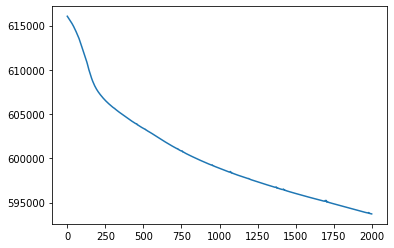

In [41]:
plt.plot(losses[8000:])

# check prediction

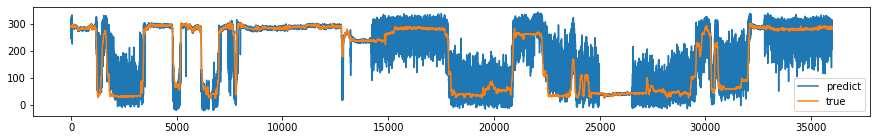

In [35]:
z = model.most_likely_states(data)
x_predict_arr = k_step_prediction(model, z, data)

plt.figure(figsize=(15,2))
plt.plot(x_predict_arr[:,0], label='predict')
plt.plot(data[:,0].numpy(), label='true')
plt.legend()
plt.show()

# check samples

In [31]:
sample_z, sample_x = model.sample(500)

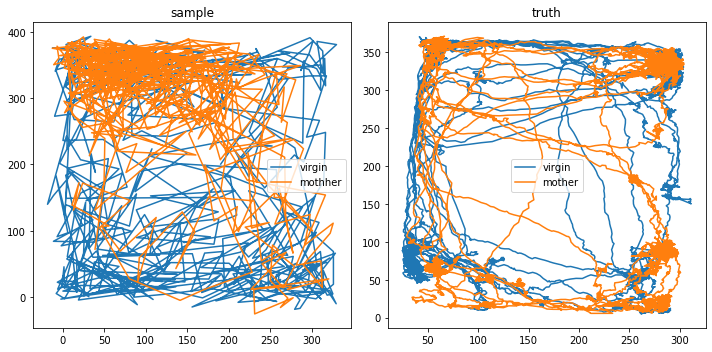

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(sample_x[:,0], sample_x[:,1], label='virgin')
axs[0].plot(sample_x[:,2], sample_x[:, 3], label='mothher')
axs[0].legend()
axs[0].set_title('sample')

axs[1].plot(traj29[:,0], traj29[:,1], label='virgin')
axs[1].plot(traj29[:,2], traj29[:,3], label='mother')
axs[1].legend()
axs[1].set_title('truth')

plt.tight_layout()

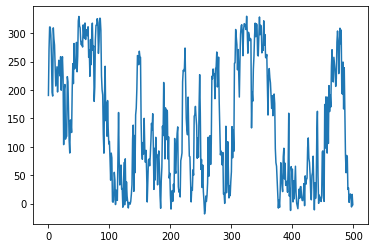

In [33]:
plt.plot(sample_x[:,0])

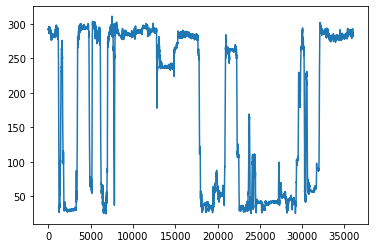

In [34]:
plt.plot(traj29[:,0])

#### train for another 5000 iters

In [42]:
pbar = tqdm(total=num_iters, file=sys.stdout)

for i in np.arange(num_iters):

    optimizer.zero_grad()

    loss = model.loss(data)
    loss.backward(retain_graph=True)
    optimizer.step()
    losses.append(loss.detach().numpy())
    
    if i % 10 == 0:
        pbar.set_description('iter {} loss {:.2f}'.format(i, loss))
        pbar.update(10)
        
pbar.close()

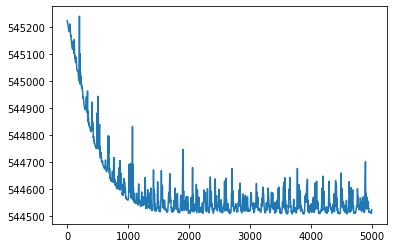

In [44]:
plt.plot(losses[15000:])

## check prediction

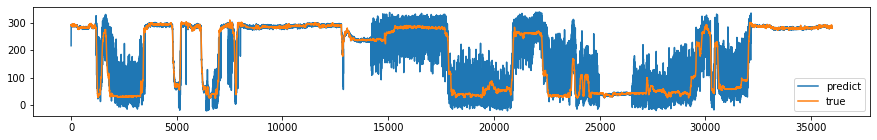

In [45]:
z = model.most_likely_states(data)
x_predict_arr = k_step_prediction(model, z, data)

plt.figure(figsize=(15,2))
plt.plot(x_predict_arr[:,0], label='predict')
plt.plot(data[:,0].numpy(), label='true')
plt.legend()
plt.show()

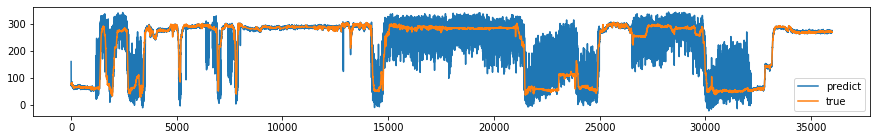

In [46]:
plt.figure(figsize=(15,2))
plt.plot(x_predict_arr[:,2], label='predict')
plt.plot(data[:,2].numpy(), label='true')
plt.legend()
plt.show()

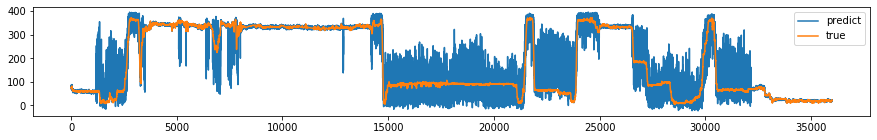

In [47]:
plt.figure(figsize=(15,2))
plt.plot(x_predict_arr[:,3], label='predict')
plt.plot(data[:,3].numpy(), label='true')
plt.legend()
plt.show()

Model fitting is not good. Possible reasons:

- model not expressive enough
- the observation sequence is too long (try tuning the number of states, AR lags)

In [48]:
losses[-1]

array(544524.00776786)